In [1]:
# Python-pakker:

# import sympy 
from sympy import *
init_printing(use_unicode=True)

# improt numpay:
import numpy as np

# bruges til at lave dot over a frem for d/dt
from sympy.physics.mechanics import init_vprinting
init_vprinting()

# bruges til at opsille lininger visuelt: 
from IPython.display import Latex, display, Image, Math

# Bruges til at få udtryke via brøker istedet for desimaltal:
from fractions import Fraction

import sympy as sp

In [2]:
# Koden, der udregner Friedmann-ligningerne:

i = [0,1,2,3]
x = [Symbol('t'), Symbol('r'), Symbol('θ'), Symbol('φ')] # 4-vektor i sværiske kordinater 
K = 8 * Symbol('π G')
CS_symbol = Symbol('Γ^μ_αβ')
ro , P , L , k , Gamma = Symbol('ρ') , Symbol('P') , Symbol('Λ') , Symbol('k'), Symbol('Γ') 
a = Function('a')(x[0]) # skalafactor 
r = (x[1])
ø = (x[2])
tal = [Symbol('0'), Symbol('1'), Symbol('2'), Symbol('3')]

# metrikken g_αβ :
g = Matrix([[-1,0,0,0],
            [0,a**2/(1-k*r**2),0,0],
            [0,0,a**2 *r**2,0],
            [0,0,0,a**2 *r**2 *sin(ø)**2]])


g_i = g**(-1) # den inverse metrik g^αβ

u = [-1,0,0,0] # 4-hastighed

a_dot  = (diff(a, x[0], 1)) # ȧ
a_2dot  = (diff(a, x[0], 2)) # ä
H  = (diff(a, x[0], 1)) / a # H ≡ ȧ/a

# General funktion der bruges til at tage 4*4 output fra en (anden) funktion og indeætter dem i en 4x4 matrix:
def tensor(f):
    A2 = []
    for iii in i:
        A1 = []
        for ii in i:
            A = f(iii,ii)
            A1.append(A)
        A2.append(A1)
    T = Matrix(A2) # Stress Energy tensoren
    return T

# General funktion der opstiller en ligning visualt:
def lining(a,b):  
    A = simplify(a)
    B = simplify(b)
    heat_eq = ( Eq(A,B))  # liningen
    return display(heat_eq) # opstiller liningen visuelt

# General funktion der ud fra 2 lininger (L1 & L2) opstilles en 3. lining, hvor 'x' ikke indgår direkte, og som er lig med 'y'
def løs_lining(L1,L2,x,y): 
    L1_i = solve(L1,x)
    L2_i = solve(L2,x)
    L3 = Eq(L1_i[0],L2_i[0])
    L3_i = solve(L3,y)
    return L3_i
    
# g_αβ,ν:
def g_diff(alfa,beta,v): # g_αβ definseret med hensynd til x^ν 
    expr_diff = Derivative(g[alfa,beta], x[v])
    return expr_diff.doit()

# Christoffer symboler:
def CS(y,alfa,beta): # Γ^μ_αβ
    v = y # da vi har en dirgonal metrik 
    return g_i[y,v] /2 * ( g_diff(alfa,v,beta) + g_diff(beta,v,alfa) - g_diff(alfa,beta,v) ) # eq. 2.19 i Dodelson

# indexs til Stress-Energy Tensor 
def T_yv(y,v): # T_μν , https://en.wikipedia.org/wiki/Stress%E2%80%93energy_tensor#Stress%E2%80%93energy_of_a_fluid_in_equilibrium
    return (ro + P) * u[y] * u[v] + P * g[y,v]

# Stress-Energy Tensor:
SET = tensor(T_yv)

# Christoffer symbol differnseret: 
def CSd(alfa,y,v,beta): # Γ^α_μν,β
    expr_diff = Derivative(CS(alfa,y,v), x[beta])
    return expr_diff.doit()

# indexs til Ricci Tensor: 
def R_yv(y,v): # R_yv
    R = []
    for alfa in i:
        for beta in i:
            
            # søre for at de dele som kun indeholder alfa, og ikke beta, kun medregnes 1 gang: 
            if beta == 0:
                alfa_del = CSd(alfa,y,v,alfa) - CSd(alfa,y,alfa,v)
            else:
                alfa_del = 0
            
            R_i =  alfa_del + CS(alfa,beta,alfa) * CS(beta,y,v) - CS(alfa,beta,v) * CS(beta,y,alfa) 
            R.append(R_i)
    return sum(R)

# Ricci Tensor:
RT = tensor(R_yv)

# Ricci scalar:
RS_ii = []
for y in i:
    for v in i:
        RS_i = g_i[y,v] * R_yv(y,v) # 2.36 I Dodelson
        RS_ii.append(RS_i)
RS_iii = sum (RS_ii) # sumerer 
RS = simplify (RS_iii) # simplisifiser udtrykket

# Einstein tensor:
ET = simplify( RT - Fraction(1/2) * g * RS ) # eq. 2.30 Dodelson

# venster side af en Einsteins felt eq:
EE_v = ET + L*g

# højer side af en Einsteins felt eq:
EE_h = K*SET

# løsninger til Einsteins felt eq (EFE) :
def EFE(y):
    return lining(EE_v[y,y],EE_h[y,y]) # fulde løsning til EFL udtrykt via matrix'er

# Fridman eq.
def FE(y):
       
    if y == 0: # y=0 giver løsningen til EFE(0,0)
        
        x_1 = (a_dot**2 + k)
        x_2 = a**2
        X = x_1/x_2 # del der isoleres, (ȧ^2 - k /a^2)
        
        F_i = Eq( EE_v[y,y], EE_h[y,y] ) # opstiller ligning
        F_ii = solve(F_i,x_1) 
        
    elif y == 1: # y=1 giver løsningen til EFE(1,1) (hvor et udtryk for ȧ er fundet fra EFE(0,0)) og isoler ä/a 
        
        x_1 = a_2dot 
        x_2 = a
        X = x_1/x_2 # del der isoleres, H = ä/a 
        
        # bruge funktionen "løs_lining" til at fjerne ȧ ekspilsit fra udtrykket:
        F_ii = løs_lining( Eq( EE_v[0,0], EE_h[0,0] ) , Eq(EE_v[1,1], EE_h[1,1]) , a_dot**2, x_1)
    
    F_I = F_ii[0] / x_2 # isoler for X
    return lining(X,F_I) # Fridman eq opstilles 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

⎡-1      0         0          0      ⎤
⎢                                    ⎥
⎢         2                          ⎥
⎢        a                           ⎥
⎢0   ──────────    0          0      ⎥
⎢         2                          ⎥
⎢    - k⋅r  + 1                      ⎥
⎢                                    ⎥
⎢                 2  2               ⎥
⎢0       0       r ⋅a         0      ⎥
⎢                                    ⎥
⎢                        2  2    2   ⎥
⎣0       0         0    r ⋅a ⋅sin (θ)⎦

<IPython.core.display.Latex object>

⎡-1      0         0          0      ⎤
⎢                                    ⎥
⎢         2                          ⎥
⎢    - k⋅r  + 1                      ⎥
⎢0   ──────────    0          0      ⎥
⎢         2                          ⎥
⎢        a                           ⎥
⎢                                    ⎥
⎢                  1                 ⎥
⎢0       0       ─────        0      ⎥
⎢                 2  2               ⎥
⎢                r ⋅a                ⎥
⎢                                    ⎥
⎢                             1      ⎥
⎢0       0         0    ─────────────⎥
⎢                        2  2    2   ⎥
⎣                       r ⋅a ⋅sin (θ)⎦

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

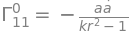

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

⎡ρ      0          0            0       ⎤
⎢                                       ⎥
⎢         2                             ⎥
⎢      P⋅a                              ⎥
⎢0  ──────────     0            0       ⎥
⎢        2                              ⎥
⎢   - k⋅r  + 1                          ⎥
⎢                                       ⎥
⎢                  2  2                 ⎥
⎢0      0       P⋅r ⋅a          0       ⎥
⎢                                       ⎥
⎢                           2  2    2   ⎥
⎣0      0          0     P⋅r ⋅a ⋅sin (θ)⎦

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

⎡-3⋅ä                                                                                                                                                    ⎤
⎢─────                   0                                0                                                     0                                        ⎥
⎢  a                                                                                                                                                     ⎥
⎢                                                                                                                                                        ⎥
⎢                                      2                                                                                                                 ⎥
⎢          2⋅k          a⋅ä        2⋅ȧ                                                                                                                 ⎥
⎢  0    ────────── + ────────── + ──────────              0          

<IPython.core.display.Latex object>

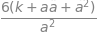

<IPython.core.display.Latex object>

⎡  ⎛     2⎞                                                                    ⎤
⎢3⋅⎝k + ȧ ⎠                                                                    ⎥
⎢──────────        0                  0                         0              ⎥
⎢     2                                                                        ⎥
⎢    a                                                                         ⎥
⎢                                                                              ⎥
⎢                         2                                                    ⎥
⎢            k + 2⋅a⋅ä + ȧ                                                     ⎥
⎢    0       ──────────────           0                         0              ⎥
⎢                  2                                                           ⎥
⎢               k⋅r  - 1                                                       ⎥
⎢                                                                              ⎥
⎢                        

<IPython.core.display.Latex object>

⎡         2      2                                                                                         ⎤                                                                
⎢3⋅k - Λ⋅a  + 3⋅ȧ                                                                                          ⎥                                                                
⎢─────────────────            0                         0                                0                 ⎥   ⎡8⋅π G⋅ρ       0              0                  0          ⎤
⎢         2                                                                                                ⎥   ⎢                                                           ⎥
⎢        a                                                                                                 ⎥   ⎢                   2                                       ⎥
⎢                                                                                                          ⎥   ⎢         -8⋅P⋅π G⋅a   

<IPython.core.display.Latex object>

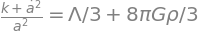

<IPython.core.display.Latex object>

In [3]:
# Denne kode giver et output, der viser en kombination af fremgangsmetoden samt resultaterne fra koden, der benyttes til at udregne Friedmann-ligningerne:

display(Latex(f'Her fremgår fremgangsmetoden i store træk for min kode.'))
display(Latex(f'Metrikken, $g_{{αβ}}$, defineres:'))
display(g)
display(Latex(f'Den inverse metrik, $g^{{αβ}}$, defineres:')) 
display(g_i)
display(Latex(f'4-hastigheden, tidsafledet og dobbelttidsafledet af skalfaktoren $u$, $\dot{{a}}$, $\ddot{{a}}$, samt Hubble-parameteren, $H$, defineres:'))
display(H)
display(Latex(f'Generelle funktioner opskrives i min kode'))
display(Latex(f'Der laves en funktion, g_diff(α,β,ν), som finder $g_{{αβ}}$ afledt mht $x^ν$.'))
display(Latex(f'Der laves en funktion, CS(μ,α,β), der giver et Christoffel-symbol, $Γ^μ_{{αβ}}$.'))
display(Latex(r'Christoffel-symboler udregnes ud fra formel: $\Gamma_{\alpha \beta}^\mu=\frac{{g^{\mu \nu}}}{2}\left[\frac{\partial g_{\alpha \nu}}{\partial x^\beta}+\frac{\partial g_{\beta \nu}}{\partial x^\alpha}-\frac{\partial g_{\alpha \beta}}{\partial x^\nu}\right]$ (Dodelson eq. 2.19).'))
display(Latex(f'De fundne Christoffel-symboler, som ikke er nul, de er:'))
for y in i:
    for alfa in i:
        for beta in i:
            if CS(y,alfa,beta) !=0 :
                Gamma = Symbol(rf'Γ^{{{tal[y]}}}_{{{tal[alfa]}{tal[beta]}}}') # Γ^μ_αβ Grafiske fremstillen af CS 
                Gammma_i = lining(Gamma,CS(y,alfa,beta))
display(Latex(f'Der laves en funktion, T_yv(μ,ν), der giver et index til Stress-Energy Tensor, $T_{{μν}}$.'))
display(Latex(r'Index til Stress-Energy Tensor, T_μν, findes via denne formel: $T^{\alpha \beta}=\left(\rho+\frac{p}{c^2}\right) u^\alpha u^\beta+p g^{\alpha \beta}$, der gælder for en perfekt væske i termodynamisk ligevægt ( https://en.wikipedia.org/wiki/Stress%E2%80%93energy_tensor#Stress%E2%80%93energy_of_a_fluid_in_equilibrium ).'))
display(Latex(f'Stress-Energy Tensoren opstilles ud fra de fundne værdier med funktionen T_yv(μ,ν), den er:'))
display(SET)
display(Latex(f'Der opstilles en funktion, CSd(α,μ,ν,β), der differentierer et Christoffel-symbol mht. $x^β$. Dette skrives som $Γ^α_{{μν,β}}$.'))
display(Latex(f'Der opstilles en funktion, R(μ,ν), der finder indekser til Ricci Tensoren.'))
display(Latex(f'Ricci Tensoren opstilles ud fra de fundne værdier med funktionen R(μ,ν), den er:'))
display(RT)
display(Latex(r'Ricci Skalaren udregnes ud fra definitionen: $\mathcal{R} \equiv g^{\mu \nu} R_{\mu \nu}$ (eq. 2.36 Dodelson), der er fundet til at være:'))
display(RS)
display(Latex(r'Einstein-tensoren udregnes ud fra formelen: $G_{\mu \nu} \equiv R_{\mu \nu}-\frac{1}{2} g_{\mu \nu} \mathcal{R}=8 \pi G T_{\mu \nu}$ (eq. 2.30 Dodelson):'))
display(ET)
display(Latex(f'Einstein-feltligningerne, $G_{{αβ}}+\Lambda g_{{αβ}}=\kappa T_{{αβ}}$, for dette tilfælde opskrives:'))
EFE(i)
display(Latex(f'Den første Friedmann-ligning findes ud fra Einsteins feltligninger:'))
# display(FE(0))
FE(0)
display(Latex(f'Den anden Friedmann-ligning findes ud fra Einsteins feltligninger:'))
# display(FE(1))
FE(1)
